In [866]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
from typing import Dict, List
import random
from typing import Tuple
from IPython.display import clear_output
from sklearn.cluster import KMeans

class Struct:
    pass

UNDEFINED: int = -1

TIPO_FOBJ: int = 3 # (1 para minimizar PAs, 2 pra minimizar distâncias)

NUM_FRONTEIRAS = 5
N_EXEC_BASE = 10
NUM_EXEC = N_EXEC_BASE**2           # Número de procuras de solução
MAX_N_EVAL = 2000
EPS_INTERVAL = [10, 30]  # Coeficiente Epsilon da soma e-restrita (com relação à minimização de PAs)
EPS_VALUE = 0

F1_WEIGHT = 1
F2_WEIGHT = 1
SUM_WEIGHT_RANGE = [0, 10]    # Pesos da soma ponderada [min PAs, min dist]

#### Class definitions

In [855]:
class Client:
    x: float
    y: float
    bandwidth: float
    id: int
    access_point_id: int = UNDEFINED
    
    def __init__(self, x_coord: str, y_coord: str, bandwidth_consumption: str) -> None:
        self.x = float(x_coord)
        self.y = float(y_coord)
        self.bandwidth = float(bandwidth_consumption)
        self.id = id

class AccessPoint:
    x: int = 0
    y: int = 0
    id: int = 0
    num_accessible_clients: int = 0
    
    def __init__(self, x_coord: int, y_coord: int, index: int) -> None:
        self.x = x_coord
        self.y = y_coord
        self.id = index
        self.num_accessible_clients: int = 0

class Solution:
    id: int = 0
    fitness: float = 0
    penalty: float = 0
    penalized_fitness: float = 0
    mean_distance: float = 0
    mean_bandwidth_usage: float = 0
    solution: Dict[int, int] = {}
    client_to_access_point: Dict[int, int] = {}
    clients_serviced_percentage = 0
    num_clients_per_access_point: Dict[int, int] = {}
    
    def __init__(self) -> None:
        self.id: int = 0
        self.fitness: float = 0
        self.penalty: float = 0
        self.penalized_fitness: float = 0
        self.mean_distance: float = 0
        self.mean_bandwidth_usage: float = 0
        self.solution: Dict[int, int] = {}
        self.client_to_access_point: Dict[int, int] = {}
        self.clients_serviced_percentage = 0
        self.num_clients_per_access_point: Dict[int, int] = {}

class ProblemData:
    access_points: List[AccessPoint] = []
    distance_ap_per_client: Dict[int, Dict[int, float]] = np.empty((81**2, 495))
    min_client_service_rate: float = 0.98
    num_clients: int = 495
    clients: List[Client] = []
    client_coords: np.array = []

#### Data definition

In [856]:
def read_clients_from_csv_file() -> List[Client] | np.array:
    # Função para ler dados de clientes de um arquivo CSV
    with open('data/clientes.csv', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        clients = []
        coords = []
        
        # Ler cada linha do arquivo CSV e criar instâncias de cliente
        for [x_coord, y_coord, bandwidth_consumption] in csv_reader:
            # Criar um novo cliente com coordenadas e consumo de largura de banda
            client = Client(x_coord, y_coord, bandwidth_consumption)
            # Adicionar o cliente à lista de clientes
            clients.append(client)
            coords.append([client.x, client.y])
        
        # Ordenar os clientes com base no consumo de largura de banda
        clients = sorted(clients, key=lambda client: client.bandwidth)
        
        # Atribuir IDs aos clientes
        for index, client in enumerate(clients):
            client.id = index
        
    return clients, coords

def define_problem_data() -> ProblemData:
    # Função para definir os dados do problema
    data = ProblemData()
    max_distance_for_access = 85
    
    # Criar pontos de acesso em uma grade 2D
    for x in range(0, 401, 5):
        for y in range(0, 401, 5):
            # Criar um novo ponto de acesso com coordenadas
            access_point = AccessPoint(x, y, len(data.access_points))
            # Adicionar o ponto de acesso à lista de pontos de acesso
            data.access_points.append(access_point)
    
    # Ler dados dos clientes do arquivo CSV
    data.clients, data.client_coords = read_clients_from_csv_file()
    
    # Calcular a distância entre pontos de acesso e clientes e contar clientes acessíveis para cada ponto de acesso
    for client in data.clients:
        for access_point in data.access_points:
            # Calcular distância entre ponto de acesso e cliente
            distance_x = (access_point.x - client.x) ** 2
            distance_y = (access_point.y - client.y) ** 2
            distance = (distance_x + distance_y) ** 0.5
            # Armazenar a distância no dicionário de distâncias
            data.distance_ap_per_client[access_point.id][client.id] = distance
            
            # Verificar se o cliente está dentro do alcance do ponto de acesso
            if distance <= max_distance_for_access:
                # Incrementar o contador de clientes acessíveis para o ponto de acesso
                access_point.num_accessible_clients += 1
    
    return data

#### Solution utils

In [857]:
def activate_access_point(solution: Solution, clients_solution: Dict[int, int], problem_data: ProblemData):
    # Função para ativar um ponto de acesso e atribuir clientes a ele
    AP_bandwidth_consumption = [0]*len(solution.solution)

    for client in problem_data.clients:
        # Verificar se o cliente ainda não foi atribuído a um ponto de acesso
        not_served = clients_solution[client.id] == UNDEFINED

        if (not not_served):
            continue

        available_APs = []
        for order_id, access_point_id in enumerate(solution.solution):

            within_range = problem_data.distance_ap_per_client[access_point_id][client.id] <= 85
            if(not within_range):
                continue

            bandwidth_within_limit = (AP_bandwidth_consumption[order_id] + client.bandwidth) <= 54
            if(not bandwidth_within_limit):
                continue

            available_APs.append(access_point_id)

        available_APs.sort(key=lambda id: problem_data.distance_ap_per_client[id][client.id]) #SORT BY RANGE

        if(len(available_APs) > 0):
            # Atribuir o ponto de acesso ao cliente
            client.access_point_id = available_APs[0]
            # Atribuir o ponto de acesso ao cliente na solução
            clients_solution[client.id] = available_APs[0]
            # Aumentar o dado de consumo de banda do AP
            AP_bandwidth_consumption[order_id] += client.bandwidth
    
    solution.mean_bandwidth_usage = sum(AP_bandwidth_consumption) / len(solution.solution)

def initialize_solution(problem_data: ProblemData):
    # Função para inicializar a solução com pontos de acesso distribuídos uniformemente
    initial_solution = Solution()

    # Adicionar 30 pontos de acesso na grade 2D
    n_clusters = 10 if TIPO_FOBJ == 1 else 30
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto").fit(problem_data.client_coords)

    for point in kmeans.cluster_centers_:
        access_point_id = round(point[0]/5 + point[1]*80/5)
        initial_solution.solution[access_point_id] = access_point_id

    return initial_solution, kmeans


In [858]:
# data = define_problem_data()
# sol = initialize_solution(data)
# print(sol.solution)

#### Objective function

In [859]:

def objective_function(solution: Solution, problem_data: ProblemData) -> Solution:
    # Função objetivo para calcular o número de pontos de acesso e a penalidade da solução
    client_to_access_point: Dict[int, int] = {}
    num_clients_serviced = 0
    
    # Inicializar o mapeamento cliente para ponto de acesso com valor UNDEFINED
    for client in problem_data.clients:
        client_to_access_point[client.id] = UNDEFINED
    
    # Ativar pontos de acesso para cada cliente na solução
    activate_access_point(solution, client_to_access_point, problem_data)
    
    # Calcular o número de clientes atendidos por ponto de acesso
    solution.num_clients_per_access_point: Dict[int, int] = {}
    for client in problem_data.clients:
        if client_to_access_point[client.id] != UNDEFINED:
            num_clients_serviced += 1
            if client_to_access_point[client.id] in solution.num_clients_per_access_point:
                solution.num_clients_per_access_point[client_to_access_point[client.id]] += 1
            else:
                solution.num_clients_per_access_point[client_to_access_point[client.id]] = 1
                
    # Calcular as restrições
    min_clients_constraint = max(0, problem_data.num_clients * problem_data.min_client_service_rate -  num_clients_serviced)
    max_APs_constraint = max(0, len(solution.solution) - 30)
    penalties = min_clients_constraint**2 + max_APs_constraint**2

    if(TIPO_FOBJ >= 2):
        calc_distances: float = 0
        for CL_dist_id, PA_dist_id in client_to_access_point.items():
            calc_distances += problem_data.distance_ap_per_client[PA_dist_id][CL_dist_id]
        # penalties += (max(0, (calc_distances / num_clients_serviced - 30)))

    # Calcular a aptidão, penalidade e aptidão penalizada da solução
    match(TIPO_FOBJ):
        case 1:
            solution.fitness = len(solution.solution)
        case 2:
            solution.mean_distance = calc_distances / num_clients_serviced
            solution.fitness = solution.mean_distance
        case 3:
            solution.mean_distance = calc_distances / num_clients_serviced
            solution.fitness = len(solution.solution)*F1_WEIGHT + solution.mean_distance*F2_WEIGHT
        case 4:
            penalties += max(0, len(solution.solution) - EPS_VALUE)**2
            solution.mean_distance = calc_distances / num_clients_serviced
            solution.fitness = solution.mean_distance


    solution.penalty = penalties
    solution.penalized_fitness = solution.fitness + solution.penalty
    solution.clients_serviced_percentage = num_clients_serviced / problem_data.num_clients
    solution.client_to_access_point = client_to_access_point
    
    return solution


#### RNVS and subfunctions

In [860]:
def get_near_AP(removed_AP_id: int, movement_range: int, problem_data: ProblemData) -> int:
    removed_AP = problem_data.access_points[removed_AP_id]

    moves_x = random.choice([-movement_range, movement_range])
    new_x = removed_AP.x/5 + moves_x if removed_AP.x/5 + moves_x > 0 else 0
    new_x = new_x if new_x < 81 else 81

    remaining = movement_range - abs(moves_x)
    moves_y = random.choice([-remaining, remaining])
    new_y = removed_AP.y/5 + moves_y if removed_AP.y/5 + moves_y > 0 else 0
    new_y = new_y if new_y < 81 else 81

    near_key = new_y * 81 + new_x

    return int(near_key-1)

def shake(solution: Solution, k: int, problem_data: ProblemData) -> Solution:
    # Função para sacudir a solução, modificando aleatoriamente a solução
    new_solution = copy.deepcopy(solution)

    if k == 3:
        APs_by_usage = sorted(new_solution.num_clients_per_access_point, key=lambda
                          AP_id: new_solution.num_clients_per_access_point[AP_id])
        worst_AP_id = APs_by_usage[0]
        new_solution.solution.pop(worst_AP_id)
    
    # Substituir os pontos de acesso selecionados por novos pontos de acesso aleatórios
    index = 0
    keys = list(new_solution.solution.keys())
    gen_keys: Dict[int, int] = {}
    while index < k:
        # old_key = random.choice(keys_to_replace)
        new_key = random.choice(keys)
        
        while new_key in gen_keys:
            new_key = random.choice(keys)

        gen_keys[new_key] = 0

        new_solution.solution.pop(new_key)

        new_key = get_near_AP(new_key, k*50/5, problem_data)
        while new_key in keys:
            new_key = get_near_AP(new_key, k*50/5, problem_data)

        new_solution.solution[new_key] = new_key
        index += 1
    
    # Adicionar novos pontos de acesso se o tamanho da solução for menor que n
    if len(new_solution.solution) <= (10):
        while len(new_solution.solution) < 30:
            key = int(81**2 * random.random())
            if not key in new_solution.solution:
                new_solution.solution[key] = key
    
    return new_solution

def neighborhood_change(x: Solution, y: Solution, k: int) -> Tuple[Solution, int]:
    # Função para mudar o bairro, atualizando a solução atual se a nova solução for melhor
    if (y.penalized_fitness < x.penalized_fitness or y.penalized_fitness == x.penalized_fitness and y.clients_serviced_percentage > x.clients_serviced_percentage):
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

def best_improvement_local_search(solution: Solution, problem_data: ProblemData) -> Solution:
    # Função para realizar a busca local de melhoramento
    current_solution = copy.deepcopy(solution)
    improved = True

    # Loop até que não haja mais melhorias na solução
    while improved:
        for key in solution.solution.keys():
            improved = False
            # Sacudir a solução e aplicar a função objetivo
            new_solution = shake(current_solution, 1, problem_data)
            new_solution = objective_function(new_solution, problem_data)
            
            # Se a nova solução for melhor, atualizar a solução atual
            if new_solution.penalized_fitness < current_solution.penalized_fitness:
                current_solution = new_solution
                improved = True

    return current_solution, improved

logStr = (f'execução = 1 | Fit = Undefined | %Clientes = Undefined | Pen = Undefined')

def find_solution_using_vns(initial_solution: Solution, problem_data: ProblemData) -> Solution:
    # Função para encontrar a solução usando o VNS (Variable Neighborhood Search)
    max_num_evaluations = MAX_N_EVAL
    num_evaluations = 0
    k_max = 3
    
    current_solution = initial_solution
    new_solution = initial_solution

    history = Struct()
    history.nPAs = []
    history.meanDist = []
    history.fit = []
    history.sol = []
    history.pen = []
    history.fit_pen = []
    
    # Loop até atingir o número máximo de avaliações
    while num_evaluations < max_num_evaluations:
        if(num_evaluations%100 >= 90):
            internalLogStr = (f'[avaliacao {num_evaluations}], PAs: {len(current_solution.solution)}')
            clear_output(wait=True)
            print(logStr, "\n", internalLogStr)
        k = 1
        # Loop sobre os valores de k
        while k <= k_max:
            new_solution = shake(current_solution, k, problem_data)
            #print(f'shake: {new_solution.solution}')
            
            # Aplicar busca local de melhoramento
            """ new_solution, improved = best_improvement_local_search(new_solution, problem_data) """
            #print(f'best_improvement_local_search: {new_solution.solution}')
            new_solution = objective_function(new_solution, problem_data)
            num_evaluations += 1
            new_solution.id = num_evaluations
            
            # Verificar se a nova solução é melhor e atualizar a solução atual
            current_solution, k = neighborhood_change(current_solution, new_solution, k)
            #print(f'neighborhood_change: {current_solution.solution}')

            # Armazenar informações sobre a solução atual
            history.nPAs.append(len(current_solution.solution))
            history.meanDist.append(current_solution.mean_distance)
            history.fit.append(current_solution.fitness)
            history.sol.append(current_solution.solution)
            history.pen.append(current_solution.penalty)
            history.fit_pen.append(current_solution.penalized_fitness)
            
    return current_solution, history


#### Execution

In [861]:
# Definir dados do problema
problem_data = define_problem_data()

# Gerar solução inicial
initial_solution, kmeans = initialize_solution(problem_data)
initial_solution = objective_function(initial_solution, problem_data)

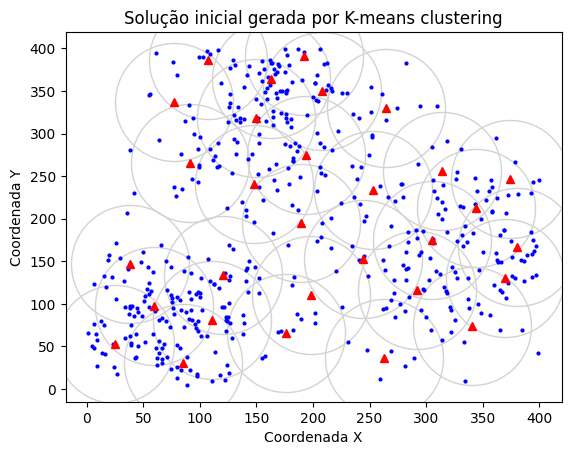

In [862]:
for cluster in kmeans.cluster_centers_:
    plt.plot(cluster[0], cluster[1], 'o', markersize=85, markerfacecolor='none', color='lightgrey', linestyle='None')

for client in problem_data.clients:
    plt.plot(client.x, client.y, marker='o', markersize=2, color='blue', linestyle='None')

for cluster in kmeans.cluster_centers_:
    plt.plot(cluster[0], cluster[1], marker='^', markersize=6, color='red', linestyle='None')

plt.title('Solução inicial gerada por K-means clustering')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')

plt.savefig('output/solucao_inicial.png')
plt.savefig('output/solucao_inicial.pdf')

In [863]:
fronteiras: List[List[Solution]] = []
historicos_de_solucoes: List[List[Struct]] = []

for bloco_exec in range(0, NUM_FRONTEIRAS):
    num_execucoes = 0
    melhores_solucoes: List[Solution] = []
    historico_atual: List[Struct] = []

    eps_values = np.arange(EPS_INTERVAL[0], EPS_INTERVAL[1], (EPS_INTERVAL[1] - EPS_INTERVAL[0])/NUM_EXEC)
    weighted_sum_values = 1+np.arange(SUM_WEIGHT_RANGE[0], SUM_WEIGHT_RANGE[1]+1, (SUM_WEIGHT_RANGE[1] - SUM_WEIGHT_RANGE[0])/np.sqrt(NUM_EXEC))

    logStr = f"[BLOCO DE EXECUÇÕES Nº {bloco_exec + 1}]"

    while num_execucoes < NUM_EXEC:

        EPS_VALUE = int(eps_values[num_execucoes])
        F1_WEIGHT = weighted_sum_values[int(num_execucoes % len(weighted_sum_values))] / 5
        F2_WEIGHT = weighted_sum_values[int(num_execucoes / len(weighted_sum_values))] / 10
        
        melhor_solucao, historico = find_solution_using_vns(initial_solution, problem_data)
        clear_output(wait=True)
        logStr += "\n"
        match TIPO_FOBJ:
            case 1:
                logStr += (f'execução = {num_execucoes+1} | Fit = {melhor_solucao.fitness} ' +
                    f'| %Clientes = {melhor_solucao.clients_serviced_percentage*100:.2f} | Pen = {melhor_solucao.penalty:.2f}')
            case 2:
                logStr += (f'execução = {num_execucoes+1} | Fit = {melhor_solucao.fitness:.2f} ' +
                    f'| %Clientes = {melhor_solucao.clients_serviced_percentage*100:.2f} | Pen = {melhor_solucao.penalty:.2f}')
            case 3:
                logStr += (f'execução = {num_execucoes+1} | Fit = {melhor_solucao.fitness:.2f} ' +
                    f'| %Clientes = {melhor_solucao.clients_serviced_percentage*100:.2f} ' +
                    f'| Pen = {melhor_solucao.penalty:.2f} | Pesos = [{F1_WEIGHT:.1f} {F2_WEIGHT:.1f}] | nPAs = {len(melhor_solucao.solution)}') 
            case 4:
                logStr += (f'execução = {num_execucoes+1} | Fit = {melhor_solucao.fitness:.2f} ' +
                    f'| %Clientes = {melhor_solucao.clients_serviced_percentage*100:.2f} ' +
                    f'| Pen = {melhor_solucao.penalty:.2f} | Eps = {EPS_VALUE} | nPAs = {len(melhor_solucao.solution)}')    
        print(logStr)
        historico_atual.append(historico)
        melhores_solucoes.append(melhor_solucao)
        num_execucoes += 1
    
    fronteiras.append(melhores_solucoes)


[BLOCO DE EXECUÇÕES Nº 1] 
 [avaliacao 98], PAs: 21


KeyboardInterrupt: 

#### Plots

In [ ]:
for historico_atual in historicos_de_solucoes:
    # Plotando a evolução da qualidade da solução candidata
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
    cores_historico = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(NUM_EXEC)]
    index_historico = 0
    for historico in historico_atual:
        s = len(historico.fit_pen)
        ax1.plot(np.linspace(0,s-1,s), historico.nPAs, '-', color=cores_historico[index_historico])
        ax2.plot(np.linspace(0,s-1,s), historico.meanDist, '-', color=cores_historico[index_historico])
        ax3.plot(np.linspace(0,s-1,s), historico.fit_pen, '-', color=cores_historico[index_historico])
        ax4.plot(np.linspace(0,s-1,s), historico.sol, ':', color=cores_historico[index_historico])
        index_historico += 1
        
    fig.suptitle('Evolução da qualidade da solução candidata')
    ax1.set_ylabel('nº de PAs')
    ax2.set_ylabel('distância média')
    ax3.set_ylabel('fitness(x) penalizado')
    ax3.set_ylabel('penalidade(x)')
    ax3.set_xlabel('Número de avaliações')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

#### Plots individuais

In [ ]:
def plot_triangle(x, y, size, color):
    plt.plot(x, y, marker='^', markersize=size, color=color, linestyle='None')

def plot_circle(x, y, size, color):
    plt.plot(x, y, marker='o', markersize=size, color=color, linestyle='None')

solution_spaces = []

for lista_solucoes in fronteiras:

    solutions_coordinates = np.zeros(shape=(len(lista_solucoes), 2))

    for sol_idx, solution in enumerate(lista_solucoes):
        # Gerar uma lista de cores aleatórias para os pontos de acesso
        access_point_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(solution.solution))]

        colors: Dict[int, str] = {}

        index = 0
        for access_point_id in solution.num_clients_per_access_point:
            colors[access_point_id] = access_point_colors[index]
            index += 1

        solutions_coordinates[sol_idx] = [len(solution.solution), solution.mean_distance]

        """ active_access_points: Dict[int, float] = {}
            
        for client_id, access_point_id in solution.client_to_access_point.items():
            if access_point_id != UNDEFINED:
                plot_triangle(problem_data.access_points[access_point_id].x, problem_data.access_points[access_point_id].y, 10, color=colors[access_point_id])
                plot_circle(problem_data.clients[client_id].x, problem_data.clients[client_id].y, 3, color=colors[access_point_id])

        # Configurar o gráfico
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        label = f'Número de PAs {len(solution.solution)} | Clientes Atendidos {solution.clients_serviced_percentage}'
        if (TIPO_FOBJ >= 2):
            label += f'\nFitness {solution.fitness:.2f} | Dist. Média {solution.mean_distance:.2f}'
        plt.title(f'Pontos de Acesso e Clientes Atendidos \n{label}')
        plt.grid(True)

        # Mostrar o gráfico
        plt.show() """
    
    solution_spaces.append(solutions_coordinates)


In [ ]:
def nondominatedsolutions(f):
    
    N = np.shape(f)[0]    
    nondominatedsolindex = np.ones(N,dtype=int)  # armazena o índice das soluções não-dominadas
    for i in np.arange(0,N,1):
        for j in np.arange(0,N,1):
            if j == i:
                continue
            if np.all(np.array(f[j,:]) <= np.array(f[i,:]))==True and np.any(np.array(f[j,:]) < np.array(f[i,:]))==True:
                nondominatedsolindex[i] = 0  # solução i é dominada
                break
        
    return nondominatedsolindex

def log_solucoes(solucoes: List[Solution], filename):
    output = ''
    for sol in solucoes:
        output += '-------------------------------------------------------\n'
        output += f'ID: {sol.id}\n'
        output += f'FITNESS: {sol.fitness:.2f}\n'
        output += f'PENALTY: {sol.penalty:.2f}\n'
        output += f'PENALIZED FITNESS: {sol.penalized_fitness:.2f}\n'
        output += f'NUMERO DE APS: {len(sol.solution)}\n'
        output += f'DISTANCIA MEDIA: {sol.mean_distance:.2f}\n'
        output += f'CONSUMO MEDIO POR PA: {sol.mean_bandwidth_usage:.2f}\n'
        output += f'CLIENTES ATENDIDOS: {sol.clients_serviced_percentage*100:.2f}%\n'
        output += '\n\n'

    with open(filename, 'w') as f:
        print(output, file=f)

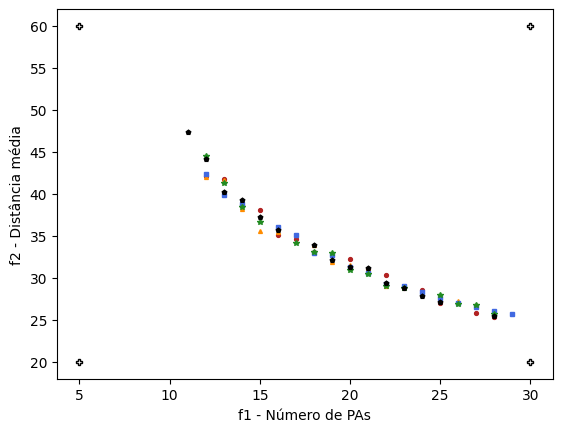

In [ ]:
colors = ['firebrick', 'darkorange', 'royalblue', 'forestgreen', 'black']
shapes = ['o', '^', 's', '*', 'p']
sizes = [5, 5, 4, 7, 6]

edge_solutions = np.array([[5, 20], [30, 20], [30, 60], [5, 60]])

plt.plot(edge_solutions[:,0], edge_solutions[:,1], 'P', color='black', markerfacecolor='none', markersize=5)

folderpath = 'output/e-restrito' if TIPO_FOBJ == 4 else 'output'
folderpath = 'output/soma_ponderada' if TIPO_FOBJ == 3 else 'output'

for idx, solution_coordinates in enumerate(solution_spaces):
    
    # print(solution_coordinates)
    nondom_bools = nondominatedsolutions(solution_coordinates)
    # print(nondom_bools)

    # Logging frontier solutions in txt files
    for i, lista_solucoes in enumerate(fronteiras):
        print_sols = []
        for j, sol in enumerate(lista_solucoes):
            if nondom_bools[j] == 1:
                print_sols.append(sol)
        log_solucoes(print_sols,
                     f'{folderpath}/soluções_fronteira_{i+1}.txt')
        
    # plt.plot(solution_coordinates[:,0], solution_coordinates[:,1],
    #          'r.', markersize=8)
    plt.plot(solution_coordinates[nondom_bools==1,0], solution_coordinates[nondom_bools==1,1],
            shapes[idx], color=colors[idx], markersize=sizes[idx]/1.8)
    
    plt.plot
    
    plt.xlabel('f1 - Número de PAs')
    plt.ylabel('f2 - Distância média')

plt.savefig(f'{folderpath}/plot_fronteiras.png')
plt.savefig(f'{folderpath}/plot_fronteiras.pdf')